In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [2]:
hbar = 1
m = 1
omega = 1

x_min = -2 * np.pi
x_max = 2 * np.pi
t_min = 0
t_max = 2 * np.pi

# PINN

In [3]:
# class PINN(tf.keras.Model):
#   def __init__(self, layers):
#     super(PINN, self).__init__()
#     self.hidden_layers = [tf.keras.layers.Dense(units, activation="tanh") for units in layers[1:-1]]
#     self.output_layer = tf.keras.layers.Dense(layers[-1], activation=None)

#   def call(self, inputs):
#     x, t = inputs
#     X = tf.stack([x, t], axis=1)

#     for layer in self.hidden_layers:
#       X = layer(X)

#     output = self.output_layer(X)
#     psi_real = output[:, 0]
#     psi_imag = output[:, 1]
#     return psi_real, psi_imag
  
class PINN(nn.Module):
  def __init__(self, layers):
    super(PINN, self).__init__()
    self.hidden_layers = nn.ModuleList()
    for units in layers[1:-1]:
      self.hidden_layers.append(nn.Linear(in_features=layers[0], out_features=units))
      layers[0] = units

    self.output_layer = nn.Linear(layers[-2], layers[-1])

  def forward(self, inputs):
    x, t = inputs
    X = torch.stack((x, t), dim=1)

    for layer in self.hidden_layers:
      X = layer(X)
      X = torch.tanh(X)

    output = self.output_layer(X)
    psi_real = output[:, 0]
    psi_img = output[:, 1]

    return psi_real, psi_img

In [4]:
layers = [2, 512, 512, 512, 512, 512, 512, 2]

In [5]:
n_collocation = 3140
n_initial = 314
n_boundary = 200

In [6]:
def generator():
    x_collocation = np.random.uniform(x_min, x_max, n_collocation)
    t_collocation = np.random.uniform(t_min, t_max, n_collocation)
    
    x_initial = np.random.uniform(x_min, x_max, n_initial)
    t_initial = np.full(n_initial, t_min)
    
    x_boundary = np.concatenate([np.full(n_boundary // 2, x_min), np.full(n_boundary // 2, x_max)])
    t_boundary = np.random.uniform(t_min, t_max, n_boundary)

    x_collocation_torch = torch.from_numpy(x_collocation).float()
    t_collocation_torch = torch.from_numpy(t_collocation).float()

    x_initial_torch  = torch.from_numpy(x_initial).float()
    t_initial_torch  = torch.from_numpy(t_initial).float()

    x_boundary_torch = torch.from_numpy(x_boundary).float()
    t_boundary_torch = torch.from_numpy(t_boundary).float()

    return x_collocation_torch, t_collocation_torch, x_initial_torch, t_initial_torch, x_boundary_torch, t_boundary_torch


In [8]:
model = PINN(layers)

In [9]:
optimizer = torch.optim.Adam(
  model.parameters(),
  lr=0.001,
  betas=(0.09, 0.999)
)

a0 = 0.001
decay_rate = 0.9
steps = 2000

def exp_decay(step):
  return a0 ** (step / steps)

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, exp_decay)

In [21]:
def loss_function():
  x_collocation_torch, t_collocation_torch, x_initial_torch, t_initial_torch, x_boundary_torch, t_boundary_torch = generator()

  #pde loss
  x_collocation_torch = x_collocation_torch.clone().requires_grad_(True)
  t_collocation_torch = t_collocation_torch.clone().requires_grad_(True)

  psi_real, psi_img = model((x_collocation_torch, t_collocation_torch))
  psi = psi_real + 1j * psi_img

  d_psi_dx = torch.autograd.grad(psi, x_collocation_torch, grad_outputs=torch.ones_like(psi), create_graph=True)[0]
  d_psi_dt = torch.autograd.grad(psi, t_collocation_torch, grad_outputs=torch.ones_like(psi), create_graph=True)[0]
  d2_psi_dx2 = torch.autograd.grad(d_psi_dx, x_collocation_torch, grad_outputs=torch.ones_like(d_psi_dx), create_graph=True)[0]

  residual = 1j * d_psi_dt + 0.5 * d2_psi_dx2 - 0.5 * (x_collocation_torch ** 2) * psi
  physics_loss = torch.mean(torch.abs(residual) ** 2)




  #initial condition loss
  psi_real_initial, psi_img_initial = model((x_initial_torch, t_initial_torch))
  psi_initial = psi_real_initial + 1j * psi_img_initial

  psi_0 = ((1 / np.pi) ** 0.25) * torch.exp(-0.5 * (x_initial_torch ** 2))
  psi_1 = psi_0 * np.sqrt(2) * x_initial_torch
  psi_initial_actual = (psi_0 + psi_1) / np.sqrt(2)

  initial_condition_loss = torch.mean(torch.abs(psi_initial - psi_initial_actual) ** 2)




  #boundary condition loss
  psi_real_boundary, psi_img_boundary = model((x_boundary_torch, t_boundary_torch))
  psi_boundary = psi_real_boundary + 1j * psi_img_boundary
  boundary_condition_loss = torch.mean(torch.abs(psi_boundary) ** 2)

  return physics_loss, initial_condition_loss, boundary_condition_loss

In [22]:
epochs = 50000
history = []

for epoch in range(1, epochs+1):
  optimizer.zero_grad()

  physics_loss, initial_condition_loss, boundary_condition_loss = loss_function()
  total_loss = physics_loss + initial_condition_loss + boundary_condition_loss

  total_loss.backward()
  optimizer.step()
  scheduler.step()

  history.append({"total_loss": total_loss.item() ,"physics_loss": physics_loss.item(), "initial_condition_loss": initial_condition_loss.item(), "boundary_condition_loss": boundary_condition_loss.item()})

  if epoch % 5000 == 0:
    print(f"Epoch {epoch}/{epochs}")
    lr_now = scheduler.get_last_lr()[0]
    print(f"LR={lr_now}")
    print(f"Total loss: {total_loss.item():.4e}")
    print(f"Physics loss: {physics_loss.item():.4e}")
    print(f"Initial condition loss: {initial_condition_loss.item():.4e}")
    print(f"Boundary condition loss: {boundary_condition_loss.item():.4e}")
    print("-" * 50)
    

KeyboardInterrupt: 

In [ ]:
total_loss_history = [record['total_loss'] for record in history]
physics_loss_history = [record['physics_loss'] for record in history]
initial_condition_loss_history = [record['initial_condition_loss'] for record in history]
boundary_condition_loss_history = [record['boundary_condition_loss'] for record in history]

epochs_range = range(1, epochs + 1)

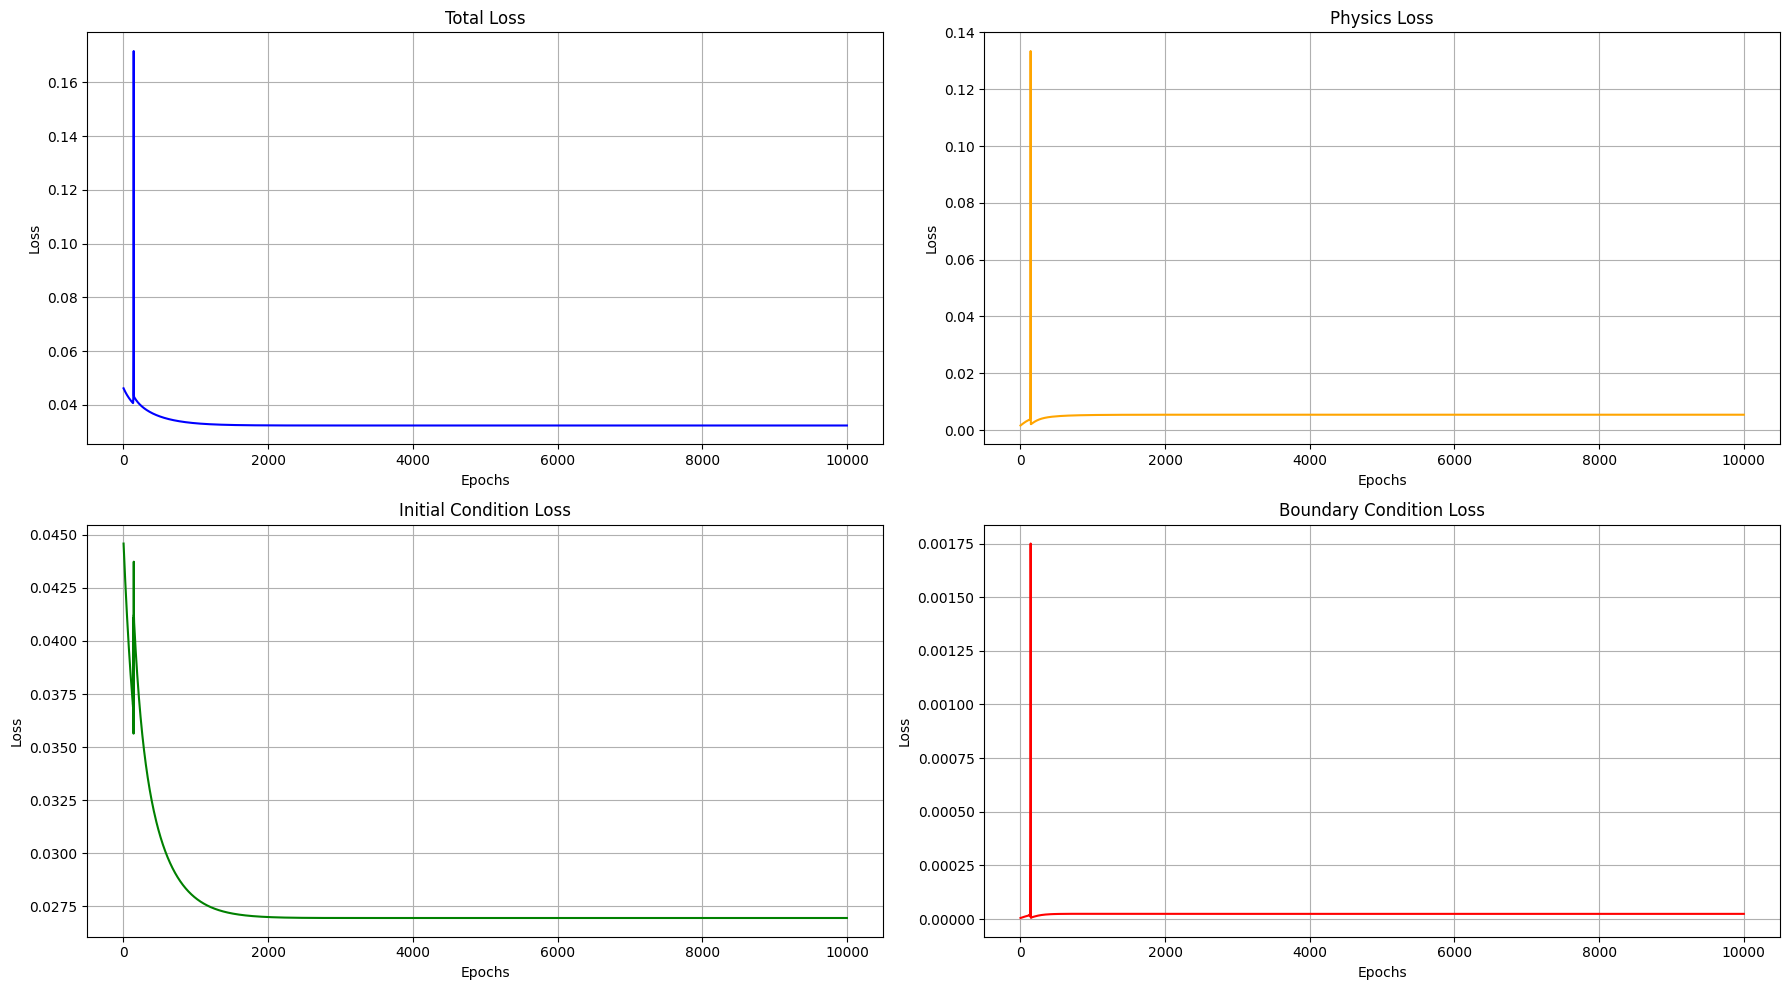

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(18, 10))

# Total Loss
axs[0, 0].plot(epochs_range, total_loss_history, color='blue')
axs[0, 0].set_title('Total Loss')
axs[0, 0].set_xlabel('Epochs')
axs[0, 0].set_ylabel('Loss')
axs[0, 0].grid(True)

# Physics Loss
axs[0, 1].plot(epochs_range, physics_loss_history, color='orange')
axs[0, 1].set_title('Physics Loss')
axs[0, 1].set_xlabel('Epochs')
axs[0, 1].set_ylabel('Loss')
axs[0, 1].grid(True)

# Initial Condition Loss
axs[1, 0].plot(epochs_range, initial_condition_loss_history, color='green')
axs[1, 0].set_title('Initial Condition Loss')
axs[1, 0].set_xlabel('Epochs')
axs[1, 0].set_ylabel('Loss')
axs[1, 0].grid(True)

# Boundary Condition Loss
axs[1, 1].plot(epochs_range, boundary_condition_loss_history, color='red')
axs[1, 1].set_title('Boundary Condition Loss')
axs[1, 1].set_xlabel('Epochs')
axs[1, 1].set_ylabel('Loss')
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()

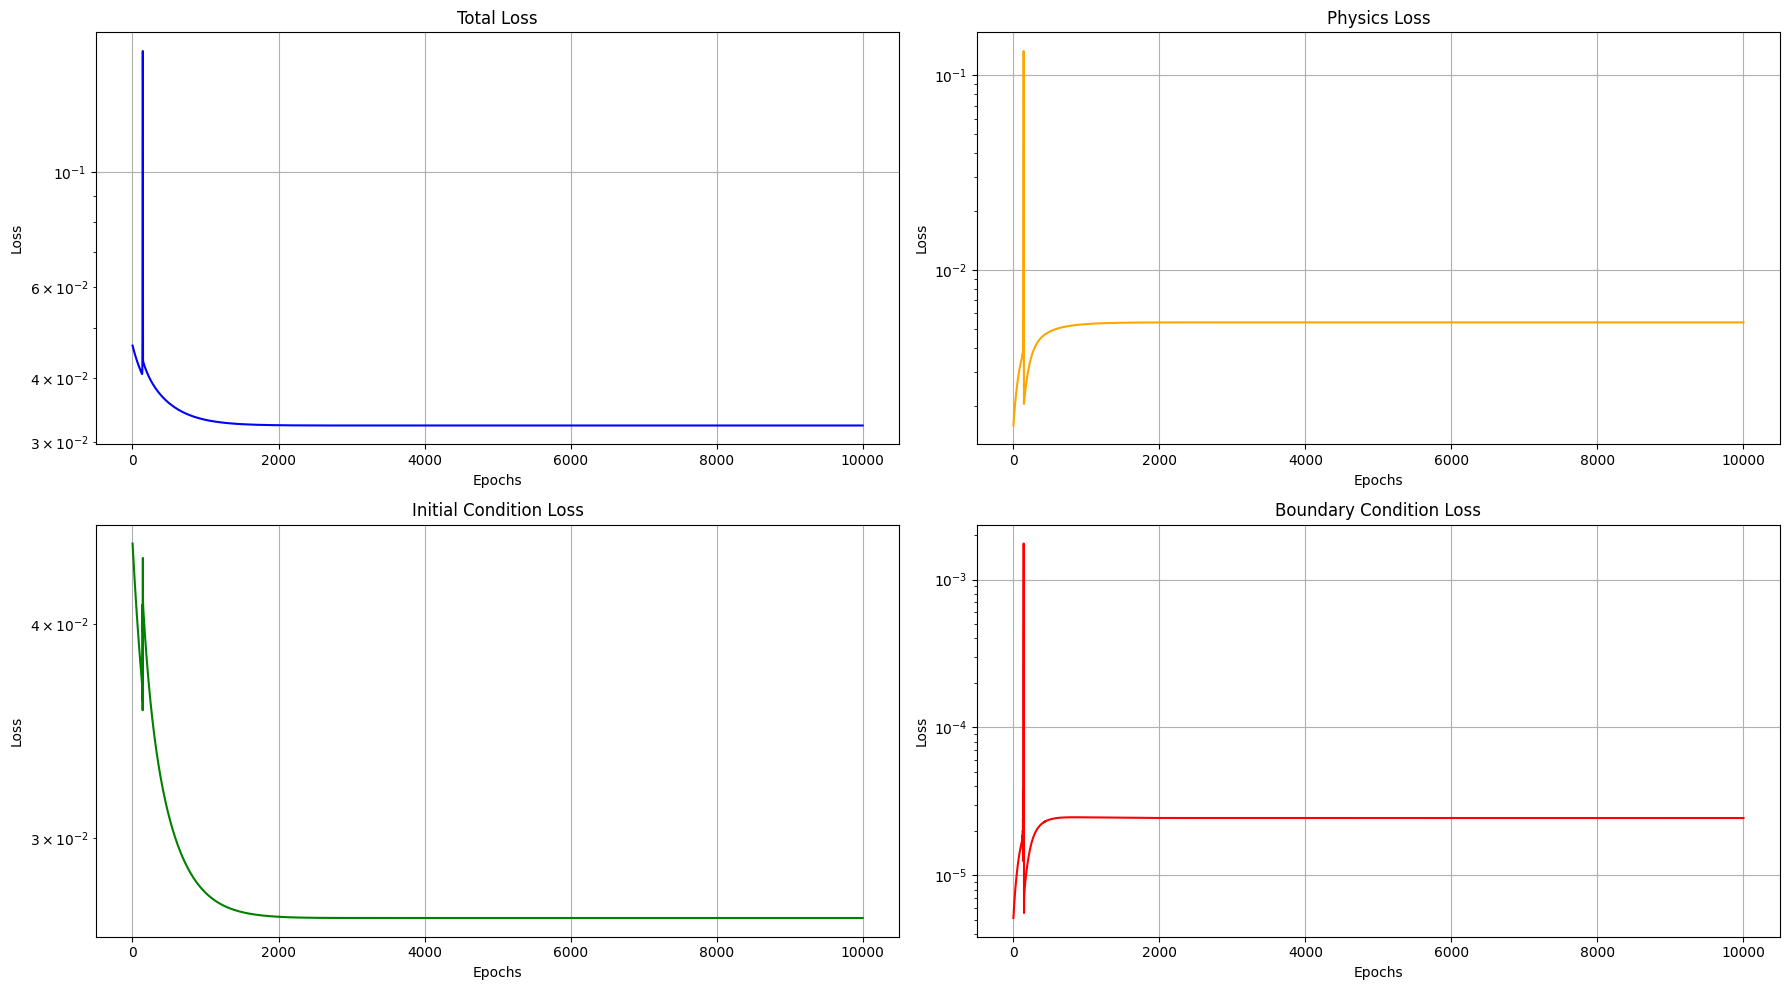

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(18, 10))

# Total Loss
axs[0, 0].plot(epochs_range, total_loss_history, color='blue')
axs[0, 0].set_title('Total Loss')
axs[0, 0].set_xlabel('Epochs')
axs[0, 0].set_ylabel('Loss')
axs[0, 0].grid(True)
axs[0, 0].set_yscale("log")

# Physics Loss
axs[0, 1].plot(epochs_range, physics_loss_history, color='orange')
axs[0, 1].set_title('Physics Loss')
axs[0, 1].set_xlabel('Epochs')
axs[0, 1].set_ylabel('Loss')
axs[0, 1].grid(True)
axs[0, 1].set_yscale("log")

# Initial Condition Loss
axs[1, 0].plot(epochs_range, initial_condition_loss_history, color='green')
axs[1, 0].set_title('Initial Condition Loss')
axs[1, 0].set_xlabel('Epochs')
axs[1, 0].set_ylabel('Loss')
axs[1, 0].grid(True)
axs[1, 0].set_yscale("log")

# Boundary Condition Loss
axs[1, 1].plot(epochs_range, boundary_condition_loss_history, color='red')
axs[1, 1].set_title('Boundary Condition Loss')
axs[1, 1].set_xlabel('Epochs')
axs[1, 1].set_ylabel('Loss')
axs[1, 1].grid(True)
axs[1, 1].set_yscale("log")

plt.tight_layout()
plt.show()

# Testing

In [ ]:
Nx = 628
Nt = 628

x_values = np.linspace(x_min, x_max, Nx)
t_values = np.linspace(t_min, t_max, Nt)

In [ ]:
def analytical(x, t):
    A = (1 / np.sqrt(2)) * ((1 / np.pi) ** 0.25) * np.exp(-(x ** 2) / 2)
    B1 = np.exp(-1j * 0.5 * t)
    B2 = np.exp(-1j * 1.5 * t) * np.sqrt(2) * x
    return A * (B1 + B2)

In [ ]:
psi_real_analytical = np.zeros((Nx, Nt), dtype=np.float64)
psi_img_analytical = np.zeros((Nx, Nt), dtype=np.float64)

for i, x in enumerate(x_values):
    for j, t in enumerate(t_values):
        psi_x_t = analytical(x, t)

        psi_real_analytical[i, j] = np.real(psi_x_t)
        psi_img_analytical[i, j] = np.imag(psi_x_t)

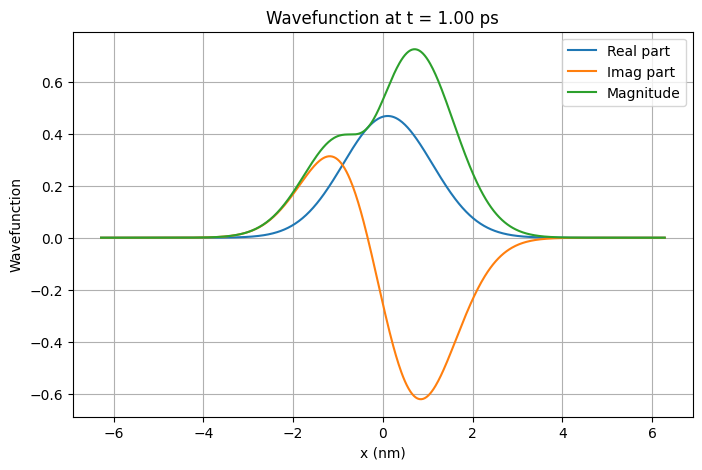

In [ ]:
time_index = 100
time_chosen = t_values[time_index]

psi_real_slice_analytical = psi_real_analytical[:, time_index]
psi_img_slice_analytical = psi_img_analytical[:, time_index]

psi_mag_slice_analytical = np.sqrt(psi_real_slice_analytical**2 + psi_img_slice_analytical**2)

plt.figure(figsize=(8,5))
plt.plot(x_values, psi_real_slice_analytical, label='Real part')
plt.plot(x_values, psi_img_slice_analytical, label='Imag part')
plt.plot(x_values, psi_mag_slice_analytical, label='Magnitude')
plt.title(f'Wavefunction at t = {time_chosen:.2f} ps')
plt.xlabel('x (nm)')
plt.ylabel('Wavefunction')
plt.legend()
plt.grid(True)
plt.show()


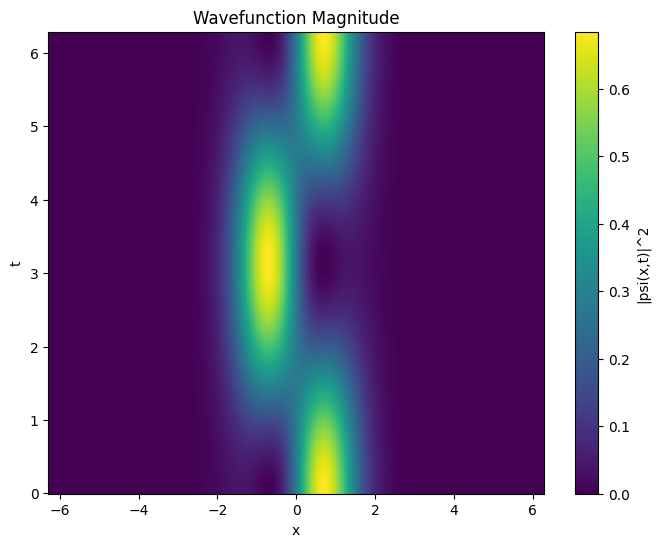

In [ ]:
plt.figure(figsize=(8, 6))
psi_sq = psi_real_analytical ** 2 + psi_img_analytical ** 2

plt.pcolormesh(x_values, t_values, psi_sq.transpose(), shading="auto")
plt.colorbar(label='|psi(x,t)|^2')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Wavefunction Magnitude')
plt.show()

In [ ]:
x_values_torch = torch.from_numpy(x_values).float()
t_values_torch = torch.from_numpy(t_values).float()

x_grid, t_grid = torch.meshgrid(x_values_torch, t_values_torch, indexing="ij")

x_flat = torch.reshape(x_grid, [-1])
t_flat = torch.reshape(t_grid, [-1])

psi_real_pinn, psi_img_pinn = model((x_flat, t_flat))

psi_real_pinn = torch.reshape(psi_real_pinn, (Nx, Nt))
psi_img_pinn = torch.reshape(psi_img_pinn, (Nx, Nt))

psi_real_pinn = psi_real_pinn.detach().numpy()
psi_img_pinn = psi_img_pinn.detach().numpy()

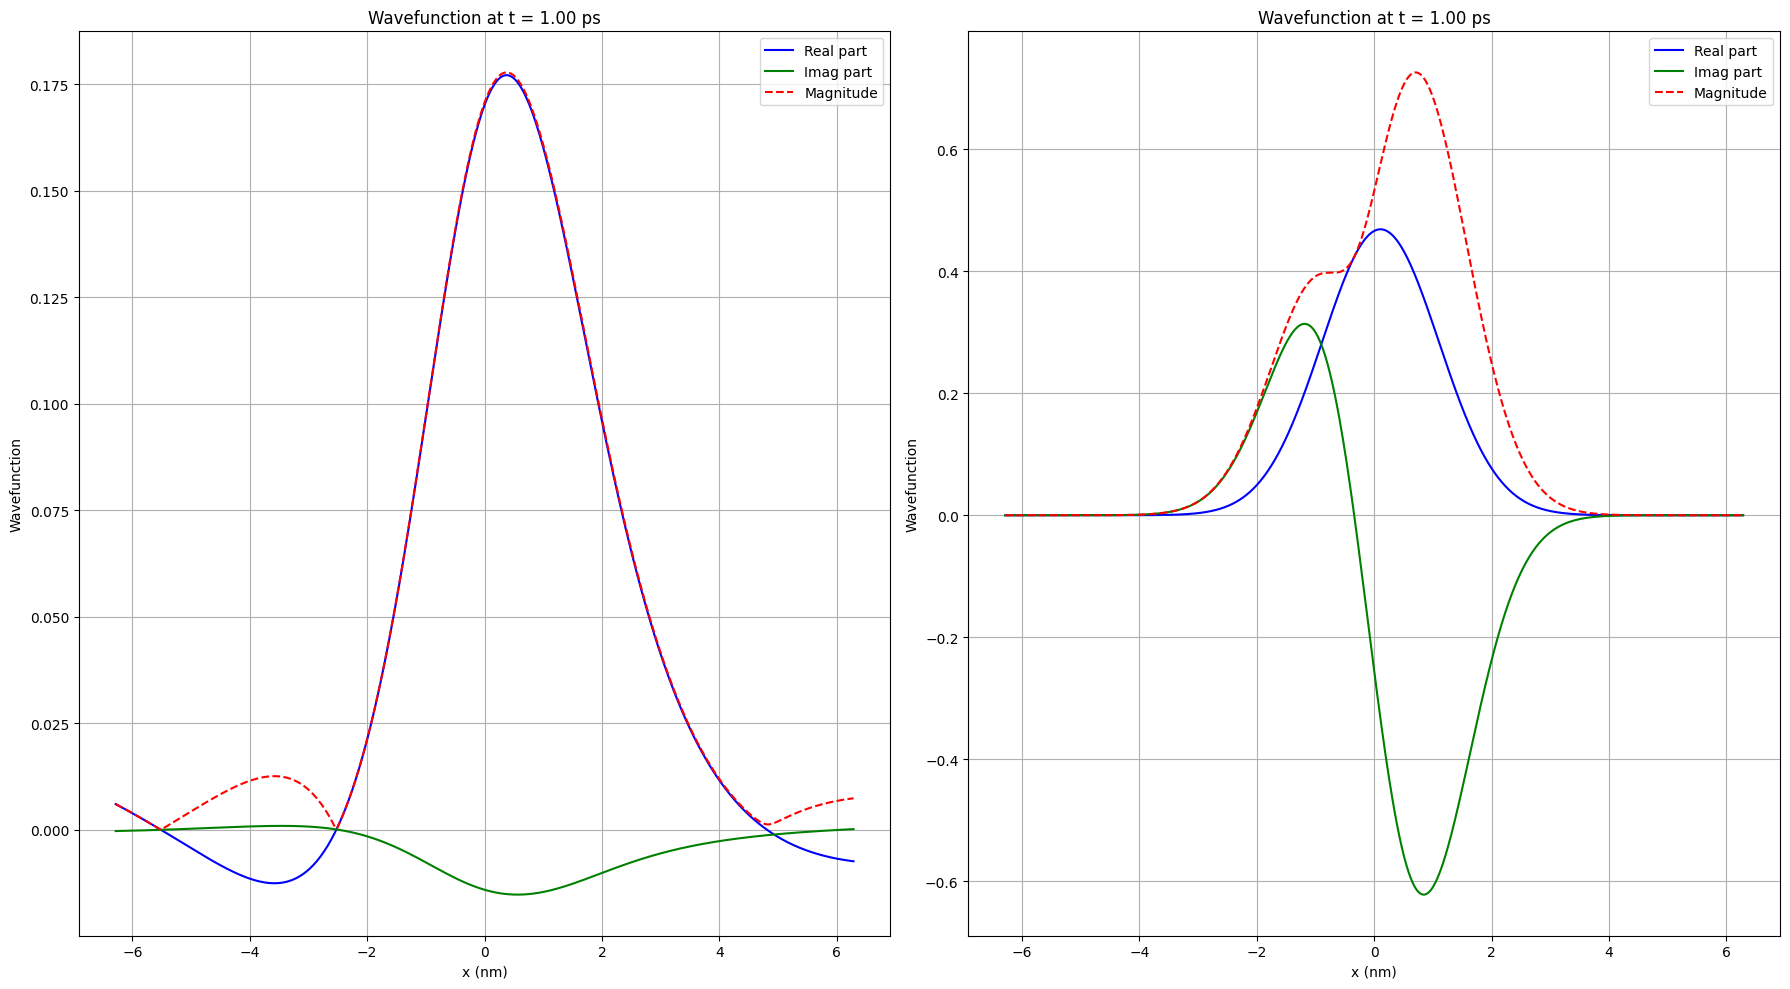

In [ ]:
time_index = 100
time_chosen = t_values[time_index]

psi_real_slice_pinn = psi_real_pinn[:, time_index]
psi_imag_slice_pinn = psi_img_pinn[:, time_index]

psi_real_slice_analytical = psi_real_analytical[:, time_index]
psi_img_slice_analytical = psi_img_analytical[:, time_index]

psi_mag_slice_pinn = np.sqrt(psi_real_slice_pinn ** 2 + psi_imag_slice_pinn ** 2)
psi_mag_slice_analytical = np.sqrt(psi_real_slice_analytical ** 2 + psi_img_slice_analytical ** 2)

fig, axs = plt.subplots(1, 2, figsize=(18, 10))

#pinn
axs[0].plot(x_values, psi_real_slice_pinn, label='Real part', color='blue')
axs[0].plot(x_values, psi_imag_slice_pinn, label='Imag part', color='green')
axs[0].plot(x_values, psi_mag_slice_pinn, '--', label='Magnitude', color='red')
axs[0].set_title(f'Wavefunction at t = {time_chosen:.2f} ps')
axs[0].set_xlabel('x (nm)')
axs[0].set_ylabel('Wavefunction')
axs[0].legend()
axs[0].grid(True)

#analytical
axs[1].plot(x_values, psi_real_slice_analytical, label='Real part', color='blue')
axs[1].plot(x_values, psi_img_slice_analytical, label='Imag part', color='green')
axs[1].plot(x_values, psi_mag_slice_analytical, '--', label='Magnitude', color='red')
axs[1].set_title(f'Wavefunction at t = {time_chosen:.2f} ps')
axs[1].set_xlabel('x (nm)')
axs[1].set_ylabel('Wavefunction')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

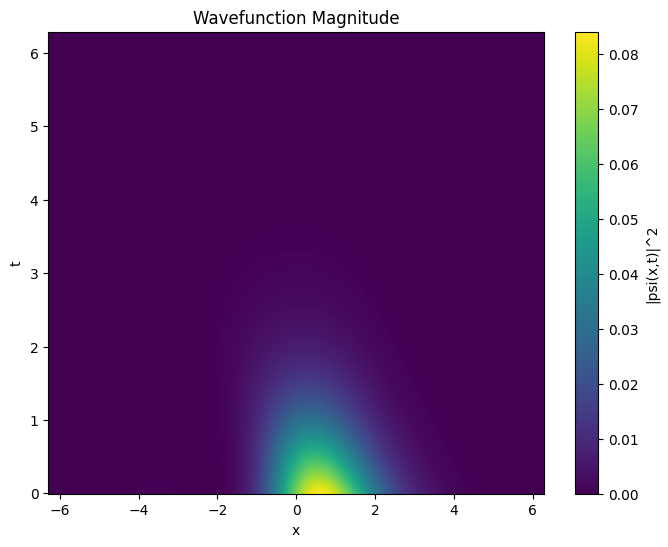

In [ ]:
plt.figure(figsize=(8, 6))
psi_sq = psi_real_pinn ** 2 + psi_img_pinn ** 2

plt.pcolormesh(x_values, t_values, psi_sq.transpose(), shading="auto")
plt.colorbar(label='|psi(x,t)|^2')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Wavefunction Magnitude')
plt.show()

In [ ]:
psi_analytical_mag = psi_real_analytical ** 2 + psi_img_analytical ** 2
psi_pinn_mag = psi_real_pinn ** 2 + psi_img_pinn ** 2

mse = (np.square(psi_analytical_mag - psi_pinn_mag)).mean()

print(f"Mean Squared Error: {mse:.3e}")

Mean Squared Error: 2.830e-02
